Step 1: Load and Preview the Data
I’ll first take a look at the contents of the CSV file to understand its structure. Then, we can proceed to clean the data and run sentiment analysis.

Let me load and preview the dataset.

The dataset contains 2,142 YouTube comments with the following columns:

author: Username of the commenter

comment: The actual comment (our focus for sentiment analysis)

likeCount: Number of likes the comment received

publishedAt: Timestamp of the comment

Next Step: Sentiment Analysis
We’ll perform sentiment analysis on the comment column. Here's a basic plan:

Preprocess the comments (remove emojis, special characters, etc.)

Detect the language (since some comments appear to be in Nepali or mixed)

Translate non-English comments to English (optional, if needed for better accuracy)

Use a sentiment analysis model to label each comment as Positive, Neutral, or Negative

In [1]:
#Import all needed libraries
from googleapiclient.discovery import build
from tqdm import tqdm
import json
import pandas as pd
import numpy as np
import seaborn as sns
import re
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

/Users/hemanta/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
#read the downloaded JSON dataset
with open("prakash_saput_comments.json", "r", encoding="utf-8") as f:
    comment_data = json.load(f)

# Now comment_data is a dictionary
print(f"Loaded {len(comment_data)} videos with comments.")

# Print first three comments of the first video
for video_id, comments in comment_data.items():
    print(f"Video ID: {video_id}")
    print("First 3 comments:", comments[:3])
    break 

Loaded 79 videos with comments.
Video ID: EL7OF3Kqw-4
First 3 comments: [{'author': '@PrakashSaput', 'comment': 'चलचित्र बसन्तमा रहेको एउटा गीत "मोटर" को लिरिकल भिडियो सार्वजनिक गरेका छौँ, चलचित्र बसन्त यहाँहरुको नजिकको हलहरुमा लागिरहेको छ, हेरेर कस्तो लाग्यो प्रतिक्रिया दिन नभुल्नुहोला।'}, {'author': '@bimalagiri1695', 'comment': 'Nice ❤💓💐'}, {'author': '@Pareshrai_official', 'comment': 'Music compose मा Jhuma limbu jiu koi name raixa , यो भाका चै पहिले देखि नै सुनि आएकोले , (सङ्कलन) राख्नु भए देखि अझ राम्रो हुनेथियो कि'}]


We can see that the comments contains Nepali, Romanized Nepali, and English language with some emoji as well.

In [6]:
# We can flatten JSON to build a pandas dataframe 
rows = []
for video_id, comment_list in comment_data.items():
    for comment in comment_list:
        # Make sure it's a dict with 'author' and 'comment'
        if isinstance(comment, dict) and 'author' in comment and 'comment' in comment:
            rows.append({
                "video_id": video_id,
                "author": comment["author"],
                "comment": comment["comment"]
            })
# Create dataFrame
df = pd.DataFrame(rows)
#save the dataframe in csv file
df.to_csv("comments.csv", index = False, escapechar='\\')

In [7]:
#Lets check top of the dataframe
df.head()

,video_id,author,comment
0,EL7OF3Kqw-4,@PrakashSaput,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक..."
1,EL7OF3Kqw-4,@bimalagiri1695,Nice ❤💓💐
2,EL7OF3Kqw-4,@Pareshrai_official,Music compose मा Jhuma limbu jiu koi name raix...
3,EL7OF3Kqw-4,@SunilsenchuryAakarengineer-y3w,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...
4,EL7OF3Kqw-4,@KRISHFF-j2e,jay Prakash saput


Lets use simple TextBolb (pretrained model) to analyzed the sentiment

In [29]:
from textblob import TextBlob
text = TextBlob("Songs are really nice heart touching plz we need other songs as well plzzz as soon as possible 🙏🙏")
print(text.sentiment)

Sentiment(polarity=0.24375000000000002, subjectivity=0.71875)


In [30]:
comment = 'Music compose मा Jhuma limbu jiu koi name raixa , यो भाका चै पहिले देखि नै सुनि आएकोले , (सङ्कलन) राख्नु भए देखि अझ राम्रो हुनेथियो कि'
text = TextBlob(comment)
print(text.sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)


In [31]:
comment = 'Dherai ramro song chha ❤❤'
text = TextBlob(comment)
print(text.sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)


TextBlob is not able to cpature roman/non english sentiment. It can only do sentiment on pure english comments. I will use multilingual BERT to analyze sentiments, as it is trained on many languages including Nepali.

In [16]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
results = sentiment_pipeline(["मलाई यो गीत धेरै राम्रो लाग्यो।", "I hated this movie."])
print(results)

2025-05-03 15:56:58.027445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Device set to use cpu


[{'label': '5 stars', 'score': 0.5550222396850586}, {'label': '1 star', 'score': 0.7954590916633606}]


In [33]:
comment = "Dherai ramro cha"
sentiment_pipeline(comment)

[{'label': '1 star', 'score': 0.2709515392780304}]

In [8]:
#Filter the comments based on english, nepali and romanized nepali
def detect_script(text):
    try:
        if re.search('[\u0900-\u097F]', text):
            return 'Nepali'
        elif detect(text) == 'en':
            return 'English'
        else:
            return 'Romanized Nepali'
    except LangDetectException:
        return 'Unknown'

In [10]:
# Apply the detect_script function to detect langauge type and visualize the distribution of comments based on language
df['language'] = df['comment'].astype(str).apply(detect_script)

# View distribution
language_counts = df['language'].value_counts()

# Optional: visualize
import matplotlib.pyplot as plt
language_counts.plot(kind='bar', color='skyblue')
plt.title('Language Distribution of Comments')
plt.ylabel('Number of Comments')
plt.xlabel('Language')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


KeyboardInterrupt



In [11]:
#visualize unknown comments 
# Filter and view unknown language rows
unknown_comments = df[df['language'] == 'Unknown']
# Show the first few unknown comments
print(unknown_comments[['comment']].head(10))

                                             comment
16  https://youtu.be/CTbuTIWvOaE?si=qLr3aNKsc83FL77G
22  https://youtu.be/qGb6SxwsZNs?si=4jTJHj-vmuU2U8ui
32                                      Wow ❤❤❤❤❤❤❤❤
36                                                ❤❤
37                                         ❤❤❤❤❤❤❤❤❤
52                                             ❤❤❤❤❤
54                                              ❤❤❤❤
60                                                🎉🎉
68                                             🎉🎉🎉🎉🎉
69                                            ❤❤❤❤❤❤


In [12]:
#save data with type of langauage in a new csv file
df.to_csv("data_with_comment_dustributions.csv", index = False, escapechar='\\')

In [13]:
#for further analysis keep only comments classified as Nepali or English
df_cleaned = df[df['language'].isin(['Nepali', 'English'])]

#Lets preview the filtered data
print(df_cleaned.head())
df_cleaned.to_csv("data_with_english_nepali_comments.csv", index = False, escapechar='\\')

       video_id                           author  \
0   EL7OF3Kqw-4                    @PrakashSaput   
2   EL7OF3Kqw-4              @Pareshrai_official   
3   EL7OF3Kqw-4  @SunilsenchuryAakarengineer-y3w   
9   EL7OF3Kqw-4                @SushmitaKC-nz5ch   
12  EL7OF3Kqw-4                    @Silent-Simma   

                                              comment language  
0   चलचित्र बसन्तमा रहेको एउटा गीत "मोटर" को लिरिक...   Nepali  
2   Music compose मा Jhuma limbu jiu koi name raix...   Nepali  
3   Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...  English  
9   Songs are really nice heart touching plz we ne...  English  
12          Wordings are great in the song. Love it🙏🏻  English  


In [14]:
#Lets check size of the data with Nepali/English comments
df_cleaned.shape

(120144, 4)

In [18]:
MAX_LEN = 512

# Truncate text to 512 characters (approx. safe range for most BERT models)
df_cleaned['short_comment'] = df_cleaned['comment'].astype(str).str.slice(0, 512)

# Apply sentiment analysis to truncated comments
df_cleaned['sentiment'] = df_cleaned['short_comment'].apply(
    lambda x: sentiment_pipeline(x)[0]['label']
)

/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_5014/2016998412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['short_comment'] = df_cleaned['comment'].astype(str).str.slice(0, 512)
/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_5014/2016998412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sentiment'] = df_cleaned['short_comment'].apply(


In [19]:
df_cleaned.head()

,video_id,author,comment,language,short_comment,sentiment
0,EL7OF3Kqw-4,@PrakashSaput,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",Nepali,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",3 stars
2,EL7OF3Kqw-4,@Pareshrai_official,Music compose मा Jhuma limbu jiu koi name raix...,Nepali,Music compose मा Jhuma limbu jiu koi name raix...,3 stars
3,EL7OF3Kqw-4,@SunilsenchuryAakarengineer-y3w,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,English,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,5 stars
9,EL7OF3Kqw-4,@SushmitaKC-nz5ch,Songs are really nice heart touching plz we ne...,English,Songs are really nice heart touching plz we ne...,5 stars
12,EL7OF3Kqw-4,@Silent-Simma,Wordings are great in the song. Love it🙏🏻,English,Wordings are great in the song. Love it🙏🏻,5 stars


In [ ]:
#Truncate long comments as BERTs input token size is 512 so truncate each comment to 512 characters
# df_cleaned['short_comment'] = df_cleaned['comment'].astype(str).str.slice(0, 512)

In [ ]:
# Apply sentiment analysis on the truncated comments
df_cleaned['sentiment'] = df_cleaned['short_comment'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_28868/4011847990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['short_comment'] = df_cleaned['comment'].astype(str).str.slice(0, 512)
/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_28868/4011847990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sentiment'] = df_cleaned['short_comment'].apply(lambda x: sentiment_pipeline(x)[0]['label'])


In [20]:
#Save the data with short comments in a csv file
df_cleaned.to_csv("data_with_short_comments_for_further_analysis.csv", index = False, escapechar='\\')

In [31]:
df_final = pd.read_csv("data_with_short_comments_for_further_analysis.csv", engine='python', escapechar='\\', on_bad_lines='skip')

In [34]:
df_final.head()

,video_id,author,comment,language,short_comment,sentiment
0,EL7OF3Kqw-4,@PrakashSaput,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",Nepali,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",3 stars
1,EL7OF3Kqw-4,@Pareshrai_official,Music compose मा Jhuma limbu jiu koi name raix...,Nepali,Music compose मा Jhuma limbu jiu koi name raix...,3 stars
2,EL7OF3Kqw-4,@SunilsenchuryAakarengineer-y3w,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,English,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,5 stars
3,EL7OF3Kqw-4,@SushmitaKC-nz5ch,Songs are really nice heart touching plz we ne...,English,Songs are really nice heart touching plz we ne...,5 stars
4,EL7OF3Kqw-4,@Silent-Simma,Wordings are great in the song. Love it🙏🏻,English,Wordings are great in the song. Love it🙏🏻,5 stars


In [36]:
#convert to numerical scale
# Extract numeric rating (1–5)
extracted = df_final['sentiment'].str.extract(r'(\d)')
df_cleaned['sentiment_score'] = extracted.dropna().astype(int)


/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_5014/1139638961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sentiment_score'] = extracted.dropna().astype(int)


<Axes: title={'center': 'Sentiment Score Distribution'}, xlabel='sentiment_score'>

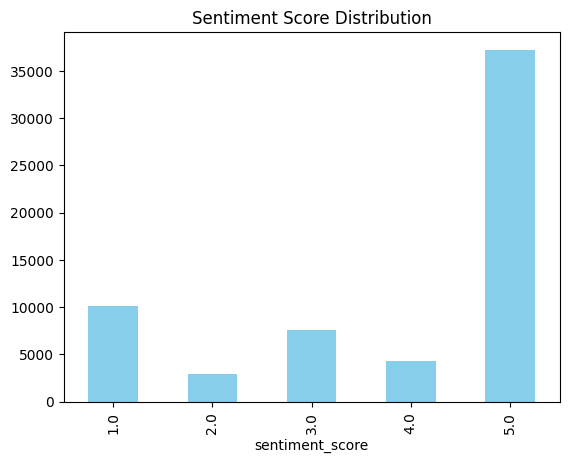

In [37]:
#Count sentiment score and plot it
df_cleaned['sentiment_score'].value_counts().sort_index().plot(kind='bar', color='skyblue', title='Sentiment Score Distribution')

In [38]:
#Set the filter only positive or negative
positive = df_cleaned[df_cleaned['sentiment_score'] >= 4]
negative = df_cleaned[df_cleaned['sentiment_score'] <= 2]

Still some of the comments that contains romanized nepali are passed through the model. We will handel them later 

In [39]:
df_cleaned.head()

,video_id,author,comment,language,short_comment,sentiment,sentiment_score
0,EL7OF3Kqw-4,@PrakashSaput,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",Nepali,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",3 stars,3.0
2,EL7OF3Kqw-4,@Pareshrai_official,Music compose मा Jhuma limbu jiu koi name raix...,Nepali,Music compose मा Jhuma limbu jiu koi name raix...,3 stars,5.0
3,EL7OF3Kqw-4,@SunilsenchuryAakarengineer-y3w,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,English,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,5 stars,5.0
9,EL7OF3Kqw-4,@SushmitaKC-nz5ch,Songs are really nice heart touching plz we ne...,English,Songs are really nice heart touching plz we ne...,5 stars,1.0
12,EL7OF3Kqw-4,@Silent-Simma,Wordings are great in the song. Love it🙏🏻,English,Wordings are great in the song. Love it🙏🏻,5 stars,4.0


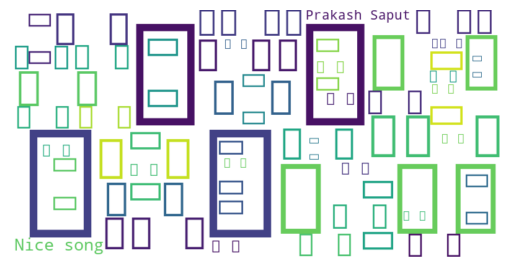

In [51]:
#Visualize top words in the comments with sentiment score high
from wordcloud import WordCloud
text_pos = " ".join(df_cleaned[df_cleaned['sentiment_score'] >= 4]['comment'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, colormap='viridis').generate(text_pos)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

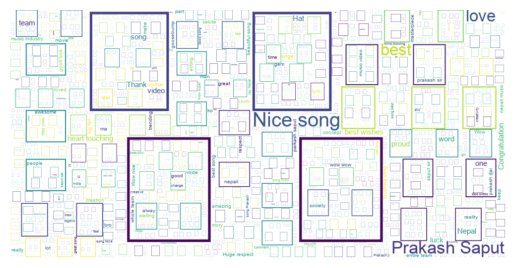

In [59]:
wordcloud = WordCloud(
    font_path = '/System/Library/Fonts/Supplemental/Arial.ttf',
    width=1000,
    height=500,
    background_color='white',
    max_words=1000
).generate(text_pos)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [52]:
from collections import Counter
from wordcloud import STOPWORDS

# Join all positive comments
text_pos = " ".join(df_cleaned[df_cleaned['sentiment_score'] >= 4]['comment'].fillna(""))

# Remove stopwords and tokenize
words = [word.lower() for word in text_pos.split() if word.lower() not in STOPWORDS]

# Count word frequency
word_freq = Counter(words)

# Display top 50 words
top_50 = word_freq.most_common(50)
for word, freq in top_50:
    print(f"{word}: {freq}")


छ: 6341
प्रकाश: 6308
को: 5497
song: 5362
गित: 4378
र: 4140
यो: 4129
राम्रो: 3967
।: 3759
पनि: 3685
prakash: 3028
गीत: 3002
धेरै: 2997
मन: 2880
मा: 2717
nice: 2704
शुभकामना: 2440
लाई: 2302
best: 2281
हो: 2248
त: 2175
wow: 2043
नै: 2008
सपूत: 2003
saput: 1992
ले: 1845
love: 1659
सपुत: 1642
❤: 1571
सबै: 1436
अनि: 1388
तर: 1285
नेपाली: 1230
बधाई: 1222
कति: 1179
म: 1132
हुन्छ: 1112
video: 1091
सफलताको: 1043
के: 973
मेरो: 966
भिडियो: 955
heart: 931
❤❤: 930
,: 927
congratulations: 919
music: 918
देश: 915
great: 897
nepali: 880


/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_5014/4142746287.py:25: UserWarning: Glyph 2331 (\N{DEVANAGARI LETTER CHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_5014/4142746287.py:25: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_5014/4142746287.py:25: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_5014/4142746287.py:25: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_5014/4142746287.py:25: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_5014/414274

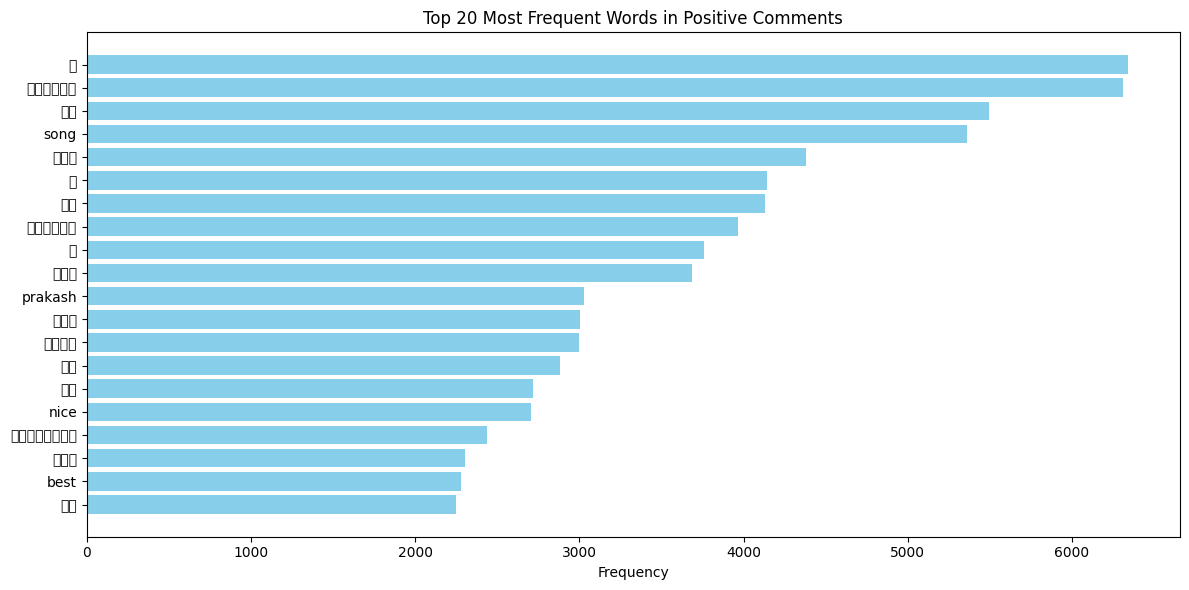

In [57]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import STOPWORDS

# Step 1: Prepare and clean the text
text_pos = " ".join(df_cleaned[df_cleaned['sentiment_score'] >= 4]['comment'].fillna(""))

# Remove stopwords and split
words = [word.lower() for word in text_pos.split() if word.lower() not in STOPWORDS]

# Step 2: Count word frequency
word_freq = Counter(words)
top_words = word_freq.most_common(20)  # Top 20 words

# Step 3: Create a DataFrame
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Step 4: Plot
plt.figure(figsize=(12, 6))
plt.barh(top_words_df['Word'], top_words_df['Frequency'], color='skyblue')
plt.xlabel("Frequency")
plt.title("Top 20 Most Frequent Words in Positive Comments")
plt.gca().invert_yaxis()  # Most frequent at the top
plt.tight_layout()
plt.show()


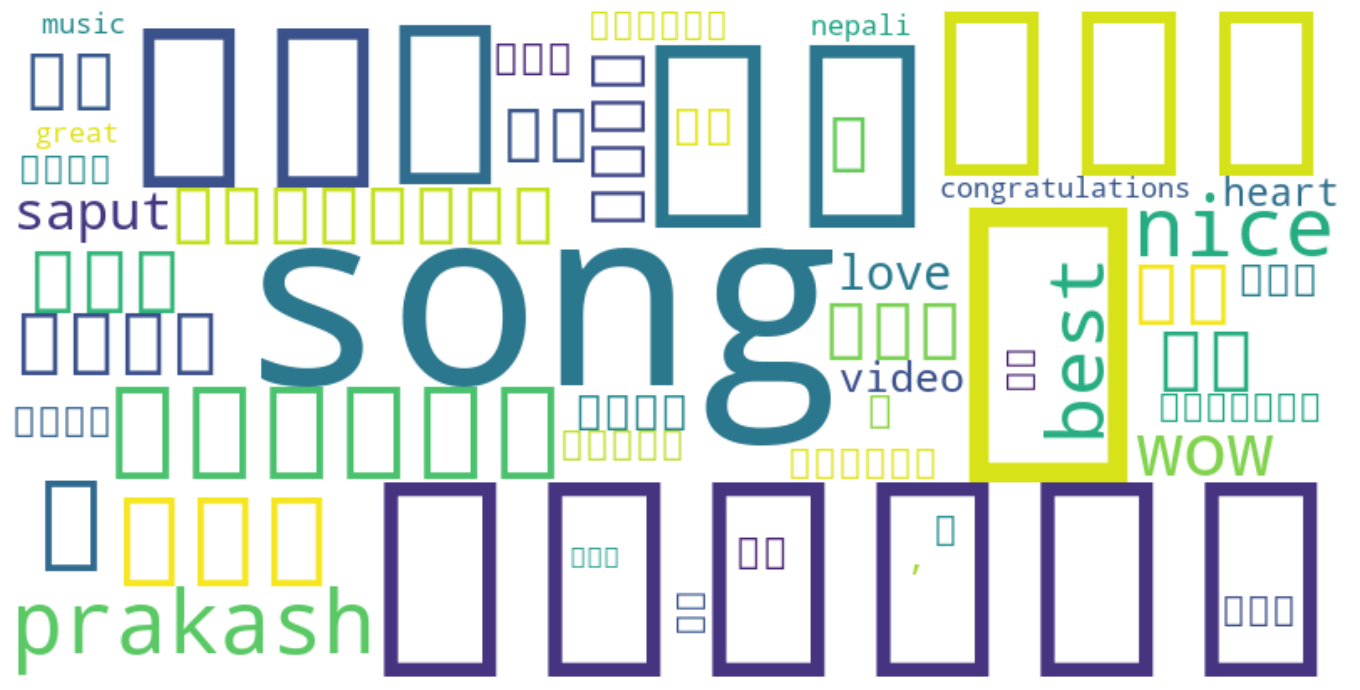

In [53]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create WordCloud from top 50 words only
top_50_dict = dict(top_50)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(top_50_dict)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()


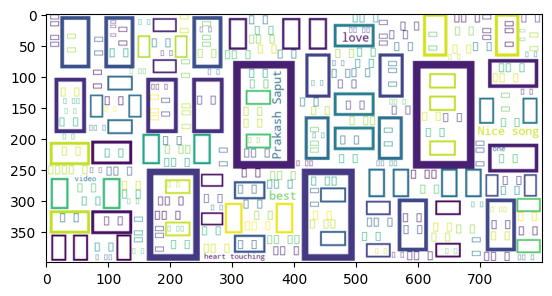

In [49]:
plt.imshow(wordcloud, interpolation='nearest')  # Blocky
plt.imshow(wordcloud, interpolation='bilinear')  # Smooth


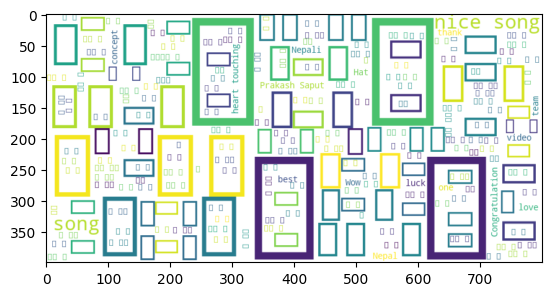

In [43]:
from wordcloud import WordCloud

text_pos = " ".join(df_cleaned[df_cleaned['sentiment_score'] < 2]['comment'])
wordcloud = WordCloud(width=800, height=400, background_color = "white").generate(text_pos)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('on')
plt.show()

In [48]:
# Convert comments to a list
comments_list = df['comment'].astype(str).tolist()


In [ ]:
batch_size = 100  # You can adjust batch size
all_results = []

for i in range(0, len(comments_list), batch_size):
    batch = comments_list[i:i+batch_size]
    batch_results = sentiment_pipeline(batch, truncation=True)
    all_results.extend(batch_results)

In [ ]:
# Add results to the DataFrame
df['sentiment_label'] = [r['label'] for r in all_results]
df['sentiment_score'] = [r['score'] for r in all_results]

# Optional: Map 1-5 stars to readable sentiment
label_map = {
    '1 star': 'Very Negative',
    '2 stars': 'Negative',
    '3 stars': 'Neutral',
    '4 stars': 'Positive',
    '5 stars': 'Very Positive'
}

df['sentiment_category'] = df['sentiment_label'].map(label_map)

In [98]:
df.head(100)

,video_id,author,comment,polarity,sentiment
0,EL7OF3Kqw-4,@PrakashSaput,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",0.0,neutral
1,EL7OF3Kqw-4,@bimalagiri1695,Nice ❤💓💐,0.6,positive
2,EL7OF3Kqw-4,@Pareshrai_official,Music compose मा Jhuma limbu jiu koi name raix...,0.0,neutral
3,EL7OF3Kqw-4,@SunilsenchuryAakarengineer-y3w,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,1.0,positive
4,EL7OF3Kqw-4,@KRISHFF-j2e,jay Prakash saput,0.0,neutral
...,...,...,...,...,...
95,EL7OF3Kqw-4,@RamkrishnaLwagun,Movie ramro dil khus huwa geet haru nai kati ...,0.0,neutral
96,EL7OF3Kqw-4,@RamkrishnaLwagun,Movie ramro dil khus huwa geet haru nai kati ...,0.0,neutral
97,EL7OF3Kqw-4,@RamkrishnaLwagun,All song’s rocks aru kahile release hunxa,0.0,neutral
98,EL7OF3Kqw-4,@basantthapa4,फिलिम हेरियो राम्रो लाग्यो हासियो पनि रोईयो पन...,0.0,neutral


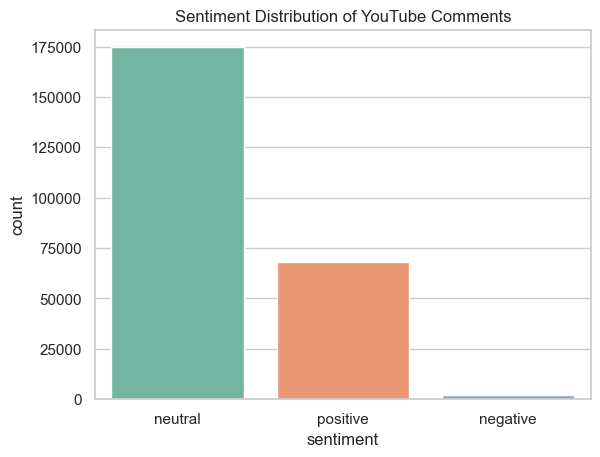

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x="sentiment", palette="Set2")
plt.title("Sentiment Distribution of YouTube Comments")
plt.show()


In [114]:
from transformers import pipeline
# Load pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

import pandas as pd
# You already have this
# df = pd.read_csv("your_file.csv")
# Optional: Use a smaller batch first if many comments
sample_df = df.copy()  # or df.head(100) for quick test
# Apply sentiment
results = sentiment_pipeline(sample_df["comment"].tolist(), truncation=True)

# Add sentiment and score to DataFrame
sample_df["sentiment"] = [res["label"] for res in results]
sample_df["score"] = [res["score"] for res in results]

print(sample_df[["author", "comment", "sentiment", "score"]].head())

label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"}

sample_df["sentiment"] = sample_df["sentiment"].map(label_map)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/hemanta/anaconda3/lib/python3.10/site-packages/transformers/utils/import_utils.py", line 1076, in _get_module
    )
  File "/Users/hemanta/anaconda3/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/hemanta/anaconda3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py", line 27, in <module>
    from ..utils import (
ImportError: cannot import name 'GENERATION_CONFIG_NAME' from 'transformers.uti

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=sample_df, x="sentiment", palette="Set2")
plt.title("Transformer-Based Sentiment on YouTube Comments")
plt.show()

NameError: name 'sample_df' is not defined

In [16]:


df = pd.read_csv('cleaned_youtube_comments.csv', engine='python', quoting=3, on_bad_lines='skip')



In [17]:
df.head()

video_id  \
EL7OF3Kqw-4 @PrakashSaput                    "चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लि...   
            @bimalagiri1695                                                           Nice ❤💓💐   
            @Pareshrai_official              "Music compose मा Jhuma limbu jiu koi name raixa    
            @SunilsenchuryAakarengineer-y3w  Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...   
            @KRISHFF-j2e                                                     jay Prakash saput   

                                                                                        author  \
EL7OF3Kqw-4 @PrakashSaput                     चलचित्र बसन्त यहाँहरुको नजिकको हलहरुमा लागिरह...   
            @bimalagiri1695                                                               None   
            @Pareshrai_official                          यो भाका चै पहिले देखि नै सुनि आएकोले    
            @SunilsenchuryAakarengineer-y3w                                               None   
            @KRISHFF-j2e                                                                  None   

                                                                                       comment  
EL7OF3Kqw-4 @PrakashSaput                     हेरेर कस्तो लाग्यो प्रतिक्रिया दिन नभुल्नुहोला।"  
            @bimalagiri1695                                                               None  
            @Pareshrai_official                 (सङ्कलन) राख्नु भए देखि अझ राम्रो हुनेथियो कि"  
            @SunilsenchuryAakarengineer-y3w                                               None  
            @KRISHFF-j2e                                                                  None

In [18]:
#preview clean data
# Check the structure and a few rows
print(df.info())
print(df.head())

# Drop rows where comment is missing
df = df.dropna(subset=['comment'])


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 275854 entries, ('EL7OF3Kqw-4', '@PrakashSaput') to ('6ktCSSRP09s', '@laxmikedarranabhat4340')
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   video_id  242934 non-null  object
 1   author    9347 non-null    object
 2   comment   2436 non-null    object
dtypes: object(3)
memory usage: 14.4+ MB
None
                                                                                      video_id  \
EL7OF3Kqw-4 @PrakashSaput                    "चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लि...   
            @bimalagiri1695                                                           Nice ❤💓💐   
            @Pareshrai_official              "Music compose मा Jhuma limbu jiu koi name raixa    
            @SunilsenchuryAakarengineer-y3w  Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...   
            @KRISHFF-j2e                                                     jay Prakash sap

In [20]:
#Basic EDA
# Count of comments
print("Total comments:", len(df))

# Count of unique authors
print("Unique commenters:", df['author'].nunique())

# Most liked comments
# top_liked = df.sort_values(by='likeCount', ascending=False).head(5)
# print(top_liked[['author', 'comment', 'likeCount']])


Total comments: 2436
Unique commenters: 1902


In [21]:
#sentiment analysis with textblob
from textblob import TextBlob

# Define function
def get_sentiment(text):
    analysis = TextBlob(str(text))
    polarity = analysis.sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment
df['Sentiment'] = df['comment'].apply(get_sentiment)

# Summary
sentiment_summary = df['Sentiment'].value_counts()
print(sentiment_summary)


Sentiment
Neutral     1969
Positive     437
Negative      30
Name: count, dtype: int64


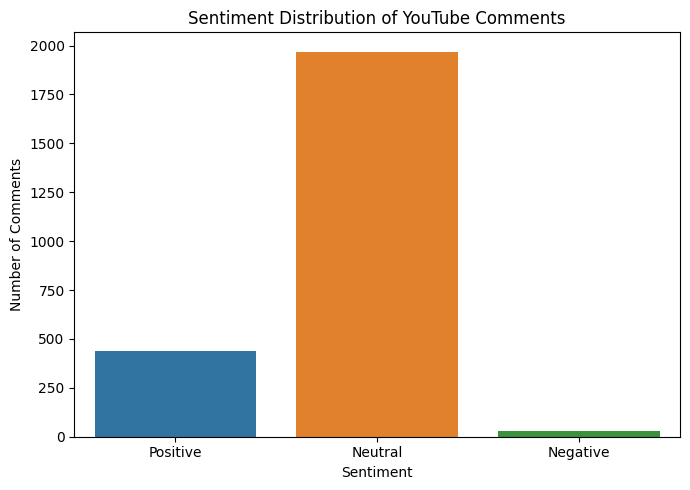

In [23]:
#visualize sentiment distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.countplot(data=df, x='Sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title("Sentiment Distribution of YouTube Comments")
plt.ylabel("Number of Comments")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()


In [24]:
df

video_id  \
EL7OF3Kqw-4 @PrakashSaput        "चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लि...   
            @Pareshrai_official  "Music compose मा Jhuma limbu jiu koi name raixa    
            @SantoshNepali-i6m               "गित राम्रो छ तर शोर चाहिँ शिव परियार   
            @bimalvlogs83        "जसको फिल्म हलमा गएर फिल्म हेर्न सक्ने क्षमता ...   
            @DenijangRai                        "film मा हरेक शब्दहरु गहकिलो थियो    
...                                                                            ...   
6ktCSSRP09s @Tsuzan_                               "I listen very few dohori songs   
            @fulmatititung7168   "prakash ji panche baja geet yakdamai ramro la...   
            @travelenepal                                         "निक्कै मन पर्यो   
            @praladchattri804                          "nice  song  bhai i like it   
            @jagatkc8136                           "प्रकाश् दाइको आफ्नै बिहेमा हो    

                                                                            author  \
EL7OF3Kqw-4 @PrakashSaput         चलचित्र बसन्त यहाँहरुको नजिकको हलहरुमा लागिरह...   
            @Pareshrai_official              यो भाका चै पहिले देखि नै सुनि आएकोले    
            @SantoshNepali-i6m                                     प्रमोद उपाध्याय   
            @bimalvlogs83                                           हामी त हेरियो    
            @DenijangRai                                    तर धेरै साहित्यिक भयो    
...                                                                            ...   
6ktCSSRP09s @Tsuzan_              I click this song accidentally but I'm glad t...   
            @fulmatititung7168         video chahi aafnai biheko hoki jasto lagyo    
            @travelenepal         गीत भनेको एक पटक सुनेपछी बारम्बार सुनिरहन मन ...   
            @praladchattri804                                                  NaN   
            @jagatkc8136                                                    ल दामी   

                                                                           comment  \
EL7OF3Kqw-4 @PrakashSaput         हेरेर कस्तो लाग्यो प्रतिक्रिया दिन नभुल्नुहोला।"   
            @Pareshrai_official     (सङ्कलन) राख्नु भए देखि अझ राम्रो हुनेथियो कि"   
            @SantoshNepali-i6m   या सुजन चापागाइ मध्य एकजनाले गाएको भए यो सङ्गि...   
            @bimalvlogs83         फिल्म गज्जब बनेको छ । सबैले एक पटक हेनुस् है।...   
            @DenijangRai                   film हेरेको जस्तो महसुस हुन अलिक सकेन ।   
...                                                                            ...   
6ktCSSRP09s @Tsuzan_              one of the best Panche Baja song. Good luck f...   
            @fulmatititung7168                 dinmai 20 choti vanda ka m herdina"   
            @travelenepal             अझ बिशेष गरि पञ्चेबाजा गित हुनाले मन छोयो😊😊    
            @praladchattri804                                                    "   
            @jagatkc8136                        लाग्यो अझै प्रगति को शुभकामना दाइ"   

                                Sentiment  
EL7OF3Kqw-4 @PrakashSaput         Neutral  
            @Pareshrai_official   Neutral  
            @SantoshNepali-i6m    Neutral  
            @bimalvlogs83         Neutral  
            @DenijangRai          Neutral  
...                                   ...  
6ktCSSRP09s @Tsuzan_             Positive  
            @fulmatititung7168    Neutral  
            @travelenepal         Neutral  
            @praladchattri804     Neutral  
            @jagatkc8136          Neutral  

[2436 rows x 4 columns]

In [28]:
from transformers import pipeline

# Load sentiment-analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [31]:
# Sample 500 comments (you can increase later)
sampled_comments = df['comment'].dropna().astype(str).sample(2436, random_state=42).tolist()

# Run transformer-based sentiment analysis
results = sentiment_pipeline(sampled_comments, truncation=True)

# Add back to DataFrame
transformer_df = pd.DataFrame({
    'comment': sampled_comments,
    'Label': [r['label'] for r in results],
    'Score': [r['score'] for r in results]
})

# Map BERT-style labels to intuitive sentiment
transformer_df['Sentiment'] = transformer_df['Label'].map({
    'POSITIVE': 'Positive',
    'NEGATIVE': 'Negative'
})

Sentiment
Negative    1311
Positive    1125
Name: count, dtype: int64


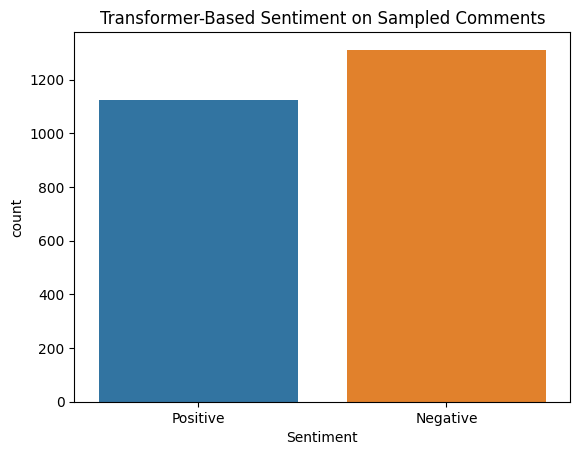

In [32]:
# Sentiment count
print(transformer_df['Sentiment'].value_counts())

# Optional: Bar plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=transformer_df, x='Sentiment')
plt.title('Transformer-Based Sentiment on Sampled Comments')
plt.show()


In [33]:
transformer_df.head()

,comment,Label,Score,Sentiment
0,shyness !!! Pure organic ! Hats up to singer ...,POSITIVE,0.999037,Positive
1,Kabita your dancing is so nice and looking be...,POSITIVE,0.999882,Positive
2,"म प्रतिक्रिया दिन चाहिन। शुभकामना सबै टिमलाई 💐""",NEGATIVE,0.821870,Negative
3,अनि अब निर्देशनमा अब्बल छु भनेर प्रमाणित गरिदि...,NEGATIVE,0.602147,Negative
4,तराई कोहि छैन पराई,NEGATIVE,0.514663,Negative


Pretrained Language Understanding:

Models like BERT or DistilBERT are pretrained on large corpora (like Wikipedia) using tasks like masked language modeling and next sentence prediction.

This gives the model a deep contextual understanding of how words relate to one another in a sentence.

Fine-tuning for Sentiment Classification:

After pretraining, the model is fine-tuned on a labeled sentiment dataset (e.g., SST-2: Stanford Sentiment Treebank).

Each input (e.g., a YouTube comment) is encoded into tokens, fed into the model, and the output is passed to a classification layer that assigns one of the classes (e.g., POSITIVE, NEGATIVE).

Scoring:

The model returns:

label: the predicted class (e.g., "POSITIVE" or "NEGATIVE")

score: the softmax probability (confidence) for the predicted label, between 0 and 1

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_matrix = tfidf.fit_transform(df['comment'].fillna(''))
top_words = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out()).sum().sort_values(ascending=False)
print(top_words)


मन         132.624504
गर         127.384006
सम         119.686416
रक         111.770550
prakash    102.691774
song        96.882028
अन          92.236252
ko          92.029874
सब          85.826623
पर          85.213354
पन          85.152437
team        84.016840
भक          78.772511
भन          74.140039
उन          65.821437
सप          63.961289
हर          58.187158
यस          47.990250
एक          46.809274
बन          43.485141
dtype: float64


In [38]:
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2786 stored elements and shape (2436, 20)>

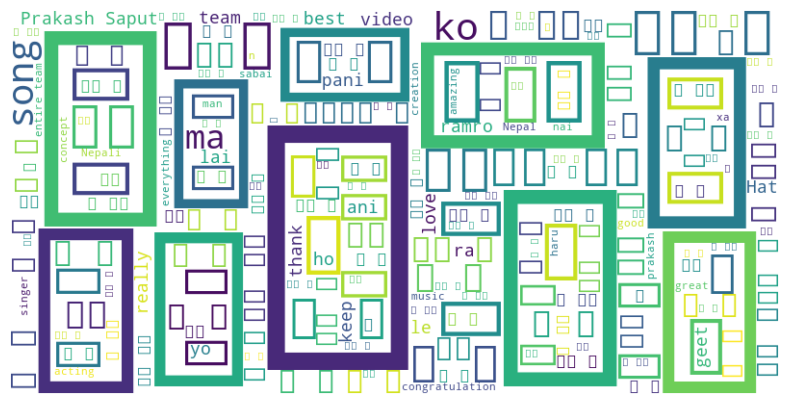

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df['comment'].dropna().astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [39]:
import pandas as pd
from transformers import pipeline

# Load dataset
df = pd.read_csv("cleaned_youtube_comments.csv", engine='python', quoting=3, on_bad_lines='skip')

# Drop missing comments
df = df.dropna(subset=['comment'])

# Load multilingual sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [40]:
import pandas as pd
from transformers import pipeline

# Load dataset
df = pd.read_csv("cleaned_youtube_comments.csv", engine='python', quoting=3, on_bad_lines='skip')

# Drop missing comments
df = df.dropna(subset=['comment'])

# Load multilingual sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")


Device set to use cpu


In [42]:
# Sample 500 comments to avoid memory overload
sampled_comments = df['comment'].astype(str).sample(500, random_state=42).tolist()

# Run the model
results = sentiment_pipeline(sampled_comments, truncation=True)

# Create result DataFrame
result_df = pd.DataFrame({
    'comment': sampled_comments,
    'Label': [r['label'] for r in results],
    'Score': [r['score'] for r in results]
})

# Map star ratings to sentiment
label_map = {
    '1 star': 'Very Negative',
    '2 stars': 'Negative',
    '3 stars': 'Neutral',
    '4 stars': 'Positive',
    '5 stars': 'Very Positive'
}
result_df['Sentiment'] = result_df['Label'].map(label_map)

# View sentiment distribution
print(result_df['Sentiment'].value_counts())


Sentiment
Very Positive    239
Very Negative    113
Neutral           87
Negative          34
Positive          27
Name: count, dtype: int64


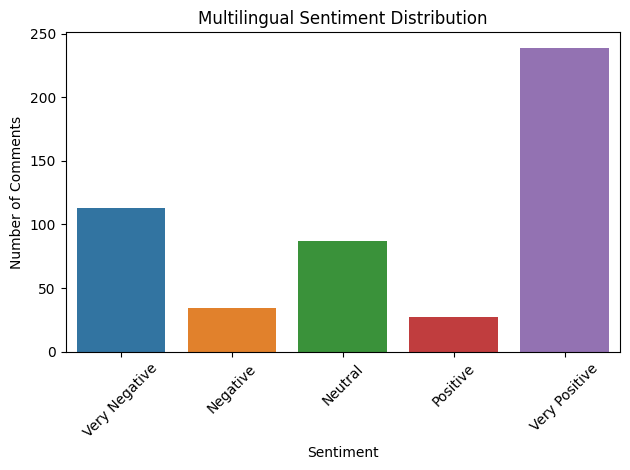

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=result_df, x='Sentiment', order=label_map.values())
plt.title("Multilingual Sentiment Distribution")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [44]:
result_df.to_csv("multilingual_sentiment_output.csv", index=False)


In [45]:
# Initial lexicon (expand this over time)
nepali_negative_words = [
    'नराम्रो', 'घृणा', 'बर्बाद', 'निकम्मा', 'असफल', 'नाली', 'दु:ख', 
    'दोषी', 'कुकर्मी', 'ठग', 'पागल', 'कुत्ता', 'दुष्ट', 'सस्तो', 'बेकार', 'हतार'
]


In [46]:
def find_nepali_neg_words(comment):
    words = str(comment).split()
    return [word for word in words if word in nepali_negative_words]


In [49]:
from langdetect import detect

# Detect language
df['language'] = df['comment'].apply(lambda x: detect(str(x)) if pd.notnull(x) else 'unknown')

# Filter for Nepali comments
df_nepali = df[df['language'] == 'ne']

# Apply the function to find negative words
df_nepali['negative_words_found'] = df_nepali['comment'].apply(find_nepali_neg_words)

# View results
df_nepali_with_neg = df_nepali[df_nepali['negative_words_found'].apply(len) > 0]
print(df_nepali_with_neg[['comment', 'negative_words_found']].head())


LangDetectException: No features in text.

In [48]:
! pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=e326ab1f4485869872584fe748d2e9abaee67eb7a89eaa1dabce6d02fa117e3a
  Stored in directory: /Users/hemanta/Library/Caches/pip/wheels/c4/16/af/1889804d8b7c0c041cadee8e29673a938a332acbf2865c70a1
Successfully built langdetect
